# 5.3 TRAINING AUTOENCODER USING IMAGE AUGMENTATION AND ADD_NOISE

In [ ]:
# Import Libraries
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from tensorflow.keras.models import save_model, load_model

# Read image from fashion_mnist dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()  # load images from dataset
x_train = x_train / 255.0
x_test = x_test / 255.0  # normalized image intensity

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train, x_test = train_test_split(x_train, test_size=0.2, random_state=42)  # create train data, test data
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)  # create train data, validation data

# Prepare Gaussian Noise Function
def add_gaussian_noise(image, noise_factor=0.3, noise_mean=0, noise_std=0.5):
    noise = noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=image.shape)
    img_noisy = image + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Clip values to the range [0, 1]
    return img_noisy

def create_autoencoder_model(optimizer, learning_rate):
    input_img = Input(shape=(28, 28, 1))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder with Dropout
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = Dropout(0.5)(x)  # Add Dropout layer
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy')
    return autoencoder

# Define ImageDataGenerator with parameters
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.1
zoom_range = 0.1
horizontal_flip = True
fill_mode='nearest'

# Set hyperparameters
eps = 50
batch_size = 32
learning_rate = 0.01

# Define ImageDataGenerator with parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=add_gaussian_noise,
    fill_mode=fill_mode)

# # Create the autoencoder model
autoencoder = create_autoencoder_model(optimizer=Adam, learning_rate=learning_rate)

# autoencoder = load_model("autoencoder_model2.h5")
# # Load the training history from the saved pickle file
# with open("training_history2.pkl", "rb") as history_file:
#     loaded_history = pickle.load(history_file)

# Define an Early Stopping callback
callback = EarlyStopping(monitor='loss', patience=10)

# Continue training the autoencoder using fit_generator
# history = autoencoder.fit_generator(
#     datagen.flow(x_train, x_train, batch_size=batch_size),
#     epochs=eps,
#     steps_per_epoch=x_train.shape[0] // batch_size,
#     validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
#     callbacks=[callback],
#     verbose=1,
#     initial_epoch=len(loaded_history['loss']))  # Specify the initial epoch

# Train the autoencoder using fit_generator
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1
)

# Save the trained autoencoder model to a file
autoencoder.save("autoencoder_model2.h5")

# Save the training history to a file using pickle
with open("training_history2.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)

313/313 [==============================] - 4s 14ms/step


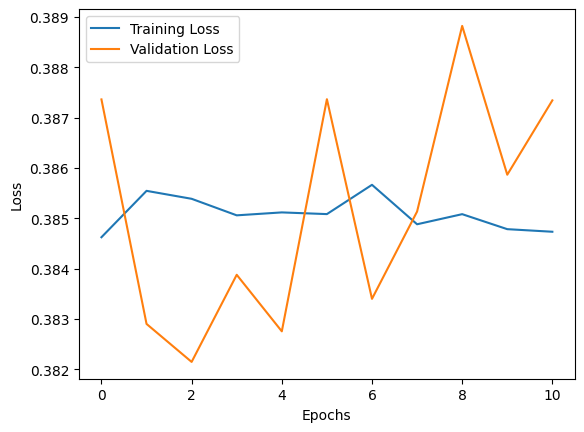

313/313 [==============================] - 4s 14ms/step


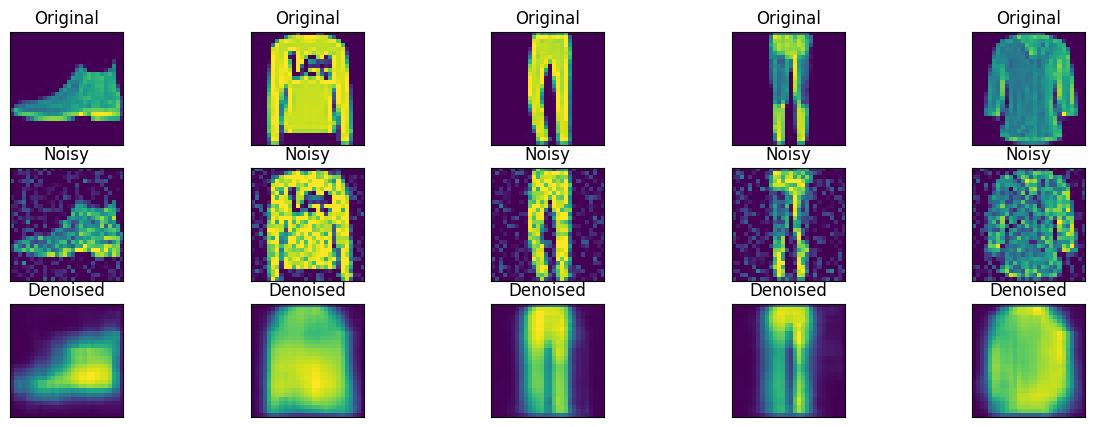

In [3]:
# Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from tensorflow.keras.models import save_model, load_model

# Load the trained autoencoder model from the saved file
autoencoder = load_model("autoencoder_model2.h5")

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, noise_factor=0.3, noise_mean=0, noise_std=0.5):
    noise = noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=image.shape)
    img_noisy = image + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Clip values to the range [0, 1]
    return img_noisy

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()  # Load images from the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0  # Normalize image intensity

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

# Load the training history from the saved pickle file
with open("training_history2.pkl", "rb") as history_file:
    loaded_history = pickle.load(history_file)

# Define the datagen variable with appropriate settings
# (Make sure to define batch_size and eps as well)
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=add_gaussian_noise,
    fill_mode=fill_mode)

# Plot Training and Validation Loss from loaded_history
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(15, 5))
for i in range(5):
    # Original image
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, 5, i + 1 + 2 * 5)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [ ]:
# Import Libraries
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from tensorflow.keras.models import save_model, load_model

# Read image from fashion_mnist dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()  # load images from dataset
x_train = x_train / 255.0
x_test = x_test / 255.0  # normalized image intensity

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train, x_test = train_test_split(x_train, test_size=0.2, random_state=42)  # create train data, test data
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)  # create train data, validation data

# Prepare Gaussian Noise Function
def add_gaussian_noise(image, noise_factor=0.2, noise_mean=0, noise_std=1):
    noise = noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=image.shape)
    img_noisy = image + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Clip values to the range [0, 1]
    return img_noisy

def create_autoencoder_model(optimizer, learning_rate):
    input_img = Input(shape=(28, 28, 1))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy')
    return autoencoder

# Define ImageDataGenerator with parameters
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
fill_mode='nearest'

# Set hyperparameters
eps = 100
batch_size = 8
learning_rate = 0.001

# Define ImageDataGenerator with parameters
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=add_gaussian_noise,
    fill_mode=fill_mode)


# # Create the autoencoder model
# autoencoder = create_autoencoder_model(optimizer=Adam, learning_rate=learning_rate)

# Load the trained autoencoder model from the saved file
autoencoder = load_model("autoencoder_model.h5")
# Load the training history from the saved pickle file
with open("training_history.pkl", "rb") as history_file:
    loaded_history = pickle.load(history_file)

# Define an Early Stopping callback
callback = EarlyStopping(monitor='loss', patience=10)

# # Train the autoencoder using fit_generator
# history = autoencoder.fit_generator(
#     datagen.flow(x_train, x_train, batch_size=batch_size),
#     epochs=eps,
#     steps_per_epoch=x_train.shape[0] // batch_size,
#     validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
#     callbacks=[callback],
#     verbose=1
# )

# Continue training the autoencoder using fit_generator
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1,
    initial_epoch=len(loaded_history['loss']))  # Specify the initial epoch

# Save the trained autoencoder model to a file
autoencoder.save("autoencoder_model.h5")

# Save the training history to a file using pickle
with open("training_history.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)

313/313 [==============================] - 5s 15ms/step


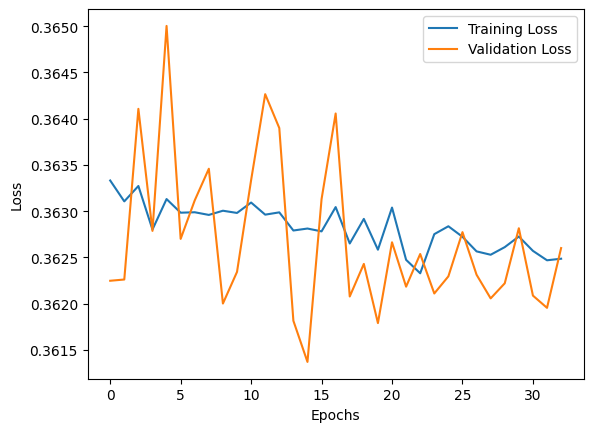

313/313 [==============================] - 5s 15ms/step


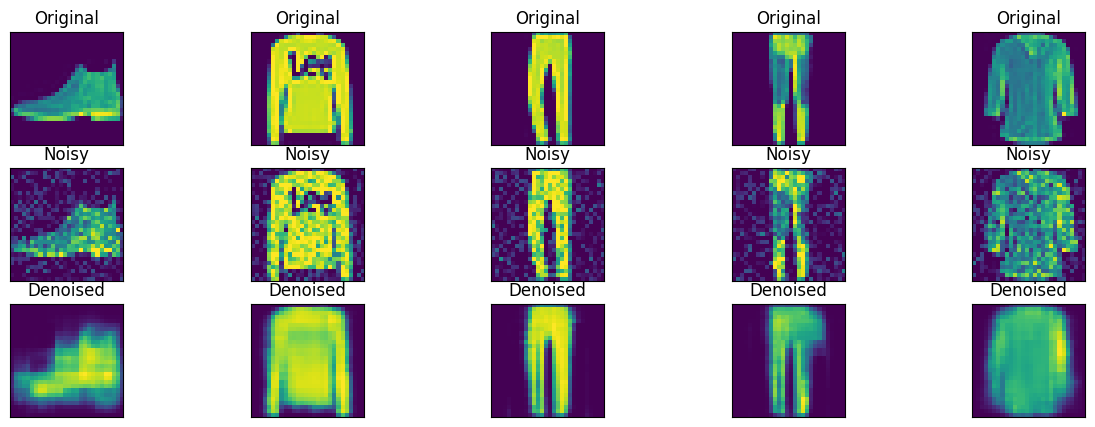

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import pickle

# Load the trained autoencoder model from the saved file
autoencoder = load_model("autoencoder_model.h5")

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, noise_factor=0.3, noise_mean=0, noise_std=0.5):
    noise = noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=image.shape)
    img_noisy = image + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Clip values to the range [0, 1]
    return img_noisy

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()  # Load images from the dataset
x_train = x_train / 255.0
x_test = x_test / 255.0  # Normalize image intensity

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

# Load the training history from the saved pickle file
with open("training_history.pkl", "rb") as history_file:
    loaded_history = pickle.load(history_file)

# Define the datagen variable with appropriate settings
# (Make sure to define batch_size and eps as well)
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=add_gaussian_noise,
    fill_mode=fill_mode)

# Plot Training and Validation Loss from loaded_history
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)

plt.figure(figsize=(15, 5))
for i in range(5):
    # Original image
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, 5, i + 1 + 2 * 5)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
